## Requirements

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
print(1)

1


In [3]:
#import os
#os.kill(os.getpid(), 9)

## Iniciation

In [4]:
!pip uninstall torch torchvision torchaudio -y
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Found existing installation: torch 2.1.0+cu121
Uninstalling torch-2.1.0+cu121:
  Successfully uninstalled torch-2.1.0+cu121
Found existing installation: torchvision 0.16.0+cu121
Uninstalling torchvision-0.16.0+cu121:
  Successfully uninstalled torchvision-0.16.0+cu121
Found existing installation: torchaudio 2.1.0+cu121
Uninstalling torchaudio-2.1.0+cu121:
  Successfully uninstalled torchaudio-2.1.0+cu121
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.7/811.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72

In [5]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [6]:
import torch
print(torch.__version__)

2.2.0+cu118


In [7]:
!pip freeze

absl-py==1.4.0
aiohttp==3.9.1
aiosignal==1.3.1
alabaster==0.7.16
albumentations==1.3.1
altair==4.2.2
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.5.0
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.14.0
backcall==0.2.0
beautifulsoup4==4.11.2
bidict==0.22.1
bigframes==0.19.2
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.4
bqplot==0.12.42
branca==0.7.0
build==1.0.3
CacheControl==0.13.1
cachetools==5.3.2
catalogue==2.0.10
certifi==2023.11.17
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.7
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.0
colorcet==3.0.1
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.0
cryptography==42.0.1
cufflinks==0.17.3
cupy-cuda12x==12.2.0
cvxopt==1.3.2
cvxpy==1.3.3
cycler==0.12.1
c

## Optimazer

In [8]:
# Based on https://github.com/pytorch/pytorch/pull/3740
import torch
import math


class AdamW(torch.optim.Optimizer):
    """Implements AdamW algorithm.

    It has been proposed in `Fixing Weight Decay Regularization in Adam`_.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)

    .. Fixing Weight Decay Regularization in Adam:
    https://arxiv.org/abs/1711.05101
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay)
        super(AdamW, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('AdamW does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # according to the paper, this penalty should come after the bias correction
                # if group['weight_decay'] != 0:
                #     grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # w = w - wd * lr * w
                if group['weight_decay'] != 0:
                    p.data.add_(-group['weight_decay'] * group['lr'], p.data)

                # w = w - lr * w.grad
                p.data.addcdiv_(-step_size, exp_avg, denom)

                # w = w - wd * lr * w - lr * w.grad
                # See http://www.fast.ai/2018/07/02/adam-weight-decay/

        return loss

## Losses

In [9]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable

try:
    from itertools import ifilterfalse
except ImportError:  # py3k
    from itertools import filterfalse

eps = 1e-6

def dice_round(preds, trues):
    preds = preds.float()
    return soft_dice_loss(preds, trues)


def iou_round(preds, trues):
    preds = preds.float()
    return jaccard(preds, trues)


def soft_dice_loss(outputs, targets, per_image=False):
    batch_size = outputs.size()[0]
    if not per_image:
        batch_size = 1
    dice_target = targets.contiguous().view(batch_size, -1).float()
    dice_output = outputs.contiguous().view(batch_size, -1)
    intersection = torch.sum(dice_output * dice_target, dim=1)
    union = torch.sum(dice_output, dim=1) + torch.sum(dice_target, dim=1) + eps
    loss = (1 - (2 * intersection + eps) / union).mean()
    return loss


def jaccard(outputs, targets, per_image=False):
    batch_size = outputs.size()[0]
    if not per_image:
        batch_size = 1
    dice_target = targets.contiguous().view(batch_size, -1).float()
    dice_output = outputs.contiguous().view(batch_size, -1)
    intersection = torch.sum(dice_output * dice_target, dim=1)
    union = torch.sum(dice_output, dim=1) + torch.sum(dice_target, dim=1) - intersection + eps
    losses = 1 - (intersection + eps) / union
    return losses.mean()


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, per_image=False):
        super().__init__()
        self.size_average = size_average
        self.register_buffer('weight', weight)
        self.per_image = per_image

    def forward(self, input, target):
        return soft_dice_loss(input, target, per_image=self.per_image)


class JaccardLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, per_image=False):
        super().__init__()
        self.size_average = size_average
        self.register_buffer('weight', weight)
        self.per_image = per_image

    def forward(self, input, target):
        return jaccard(input, target, per_image=self.per_image)


class StableBCELoss(nn.Module):
    def __init__(self):
        super(StableBCELoss, self).__init__()

    def forward(self, input, target):
        input = input.float().view(-1)
        target = target.float().view(-1)
        neg_abs = - input.abs()
        # todo check correctness
        loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
        return loss.mean()


class ComboLoss(nn.Module):
    def __init__(self, weights, per_image=False):
        super().__init__()
        self.weights = weights
        self.bce = StableBCELoss()
        self.dice = DiceLoss(per_image=False)
        self.jaccard = JaccardLoss(per_image=False)
        self.lovasz = LovaszLoss(per_image=per_image)
        self.lovasz_sigmoid = LovaszLossSigmoid(per_image=per_image)
        self.focal = FocalLoss2d()
        self.mapping = {'bce': self.bce,
                        'dice': self.dice,
                        'focal': self.focal,
                        'jaccard': self.jaccard,
                        'lovasz': self.lovasz,
                        'lovasz_sigmoid': self.lovasz_sigmoid}
        self.expect_sigmoid = {'dice', 'focal', 'jaccard', 'lovasz_sigmoid'}
        self.values = {}

    def forward(self, outputs, targets):
        loss = 0
        weights = self.weights
        sigmoid_input = torch.sigmoid(outputs)
        for k, v in weights.items():
            if not v:
                continue
            val = self.mapping[k](sigmoid_input if k in self.expect_sigmoid else outputs, targets)
            self.values[k] = val
            loss += self.weights[k] * val
        return loss


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts.float() - gt_sorted.float().cumsum(0)
    union = gts.float() + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1:  # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                    for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels


def lovasz_sigmoid(probas, labels, per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_sigmoid_flat(*flatten_binary_scores(prob.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_sigmoid_flat(*flatten_binary_scores(probas, labels, ignore))
    return loss


def lovasz_sigmoid_flat(probas, labels):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
    """
    fg = labels.float()
    errors = (Variable(fg) - probas).abs()
    errors_sorted, perm = torch.sort(errors, 0, descending=True)
    perm = perm.data
    fg_sorted = fg[perm]
    loss = torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted)))
    return loss


def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(np.isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n


class LovaszLoss(nn.Module):
    def __init__(self, ignore_index=255, per_image=True):
        super().__init__()
        self.ignore_index = ignore_index
        self.per_image = per_image

    def forward(self, outputs, targets):
        outputs = outputs.contiguous()
        targets = targets.contiguous()
        return lovasz_hinge(outputs, targets, per_image=self.per_image, ignore=self.ignore_index)


class LovaszLossSigmoid(nn.Module):
    def __init__(self, ignore_index=255, per_image=True):
        super().__init__()
        self.ignore_index = ignore_index
        self.per_image = per_image

    def forward(self, outputs, targets):
        outputs = outputs.contiguous()
        targets = targets.contiguous()
        return lovasz_sigmoid(outputs, targets, per_image=self.per_image, ignore=self.ignore_index)


class FocalLoss2d(nn.Module):
    def __init__(self, gamma=2, ignore_index=255):
        super().__init__()
        self.gamma = gamma
        self.ignore_index = ignore_index

    def forward(self, outputs, targets):
        outputs = outputs.contiguous()
        targets = targets.contiguous()
        # eps = 1e-8
        non_ignored = targets.view(-1) != self.ignore_index
        targets = targets.view(-1)[non_ignored].float()
        outputs = outputs.contiguous().view(-1)[non_ignored]
        outputs = torch.clamp(outputs, eps, 1. - eps)
        targets = torch.clamp(targets, eps, 1. - eps)
        pt = (1 - targets) * (1 - outputs) + targets * outputs
        return (-(1. - pt) ** self.gamma * torch.log(pt)).mean()

## Utils

In [10]:
import numpy as np
import cv2

#### Augmentations
def shift_image(img, shift_pnt):
    M = np.float32([[1, 0, shift_pnt[0]], [0, 1, shift_pnt[1]]])
    res = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), borderMode=cv2.BORDER_REFLECT_101)
    return res


def rotate_image(image, angle, scale, rot_pnt):
    rot_mat = cv2.getRotationMatrix2D(rot_pnt, angle, scale)
    result = cv2.warpAffine(image, rot_mat, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101) #INTER_NEAREST
    return result


def gauss_noise(img, var=30):
    row, col, ch = img.shape
    mean = var
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    gauss = (gauss - np.min(gauss)).astype(np.uint8)
    return np.clip(img.astype(np.int32) + gauss, 0, 255).astype('uint8')


def clahe(img, clipLimit=2.0, tileGridSize=(5,5)):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_LAB2RGB)
    return img_output


def _blend(img1, img2, alpha):
    return np.clip(img1 * alpha + (1 - alpha) * img2, 0, 255).astype('uint8')


_alpha = np.asarray([0.114, 0.587, 0.299]).reshape((1, 1, 3))
def _grayscale(img):
    return np.sum(_alpha * img, axis=2, keepdims=True)


def saturation(img, alpha):
    gs = _grayscale(img)
    return _blend(img, gs, alpha)


def brightness(img, alpha):
    gs = np.zeros_like(img)
    return _blend(img, gs, alpha)


def contrast(img, alpha):
    gs = _grayscale(img)
    gs = np.repeat(gs.mean(), 3)
    return _blend(img, gs, alpha)


def change_hsv(img, h, s, v):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = hsv.astype(int)
    hsv[:,:,0] += h
    hsv[:,:,0] = np.clip(hsv[:,:,0], 0, 255)
    hsv[:,:,1] += s
    hsv[:,:,1] = np.clip(hsv[:,:,1], 0, 255)
    hsv[:,:,2] += v
    hsv[:,:,2] = np.clip(hsv[:,:,2], 0, 255)
    hsv = hsv.astype('uint8')
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

def shift_channels(img, b_shift, g_shift, r_shift):
    img = img.astype(int)
    img[:,:,0] += b_shift
    img[:,:,0] = np.clip(img[:,:,0], 0, 255)
    img[:,:,1] += g_shift
    img[:,:,1] = np.clip(img[:,:,1], 0, 255)
    img[:,:,2] += r_shift
    img[:,:,2] = np.clip(img[:,:,2], 0, 255)
    img = img.astype('uint8')
    return img

def invert(img):
    return 255 - img

def channel_shuffle(img):
    ch_arr = [0, 1, 2]
    np.random.shuffle(ch_arr)
    img = img[..., ch_arr]
    return img

#######


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count



def preprocess_inputs(x):
    x = np.asarray(x, dtype='float32')
    x /= 127
    x -= 1
    return x


def dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score

    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum


def iou(im1, im2, empty_score=1.0):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    union = np.logical_or(im1, im2)
    im_sum = union.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return intersection.sum() / im_sum

## modelMscale

In [18]:
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Activation, UpSampling2D, Concatenate, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras import backend as K

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(ConvRelu, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            nn.ReLU(inplace=True, )
        )
    #@autocast()
    def forward(self, x):
        return self.layer(x)

In [19]:
"""
ResNet code gently borrowed from
https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
"""

from collections import OrderedDict
import math

import torch
import torch.nn as nn
from torch.utils import model_zoo

__all__ = ['SENet', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152',
           'se_resnext50_32x4d', 'se_resnext101_32x4d']

pretrained_settings = {
    'senet154': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/senet154-c7b49a05.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet50': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet50-ce0d4300.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet101': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet101-7e38fcc6.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet152': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet152-d17c99b7.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext50_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext101_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
}


class SEModule(nn.Module):

    def __init__(self, channels, reduction, concat=False):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x

class SCSEModule(nn.Module):
    # according to https://arxiv.org/pdf/1808.08127.pdf concat is better
    def __init__(self, channels, reduction=16, concat=False):
        super(SCSEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

        self.spatial_se = nn.Sequential(nn.Conv2d(channels, 1, kernel_size=1,
                                                  stride=1, padding=0, bias=False),
                                        nn.Sigmoid())
        self.concat = concat

    def forward(self, x):
        module_input = x

        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        chn_se = self.sigmoid(x)
        chn_se = chn_se * module_input

        spa_se = self.spatial_se(module_input)
        spa_se = module_input * spa_se
        if self.concat:
            return torch.cat([chn_se, spa_se], dim=1)
        else:
            return chn_se + spa_se

class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out


class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SCSEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SCSEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SCSEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNetBottleneck(Bottleneck):
    """
    ResNet bottleneck with a Squeeze-and-Excitation module. It follows Caffe
    implementation and uses `stride=stride` in `conv1` and not in `conv2`
    (the latter is used in the torchvision implementation of ResNet).
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False,
                               stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1,
                               groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride



class SCSEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Concurrent Spatial Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4, final=False):
        super(SCSEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SCSEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SENet(nn.Module):

    def __init__(self, block, layers, groups, reduction, dropout_p=0.2,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        """
        Parameters
        ----------
        block (nn.Module): Bottleneck class.
            - For SENet154: SEBottleneck
            - For SE-ResNet models: SEResNetBottleneck
            - For SE-ResNeXt models:  SEResNeXtBottleneck
        layers (list of ints): Number of residual blocks for 4 layers of the
            network (layer1...layer4).
        groups (int): Number of groups for the 3x3 convolution in each
            bottleneck block.
            - For SENet154: 64
            - For SE-ResNet models: 1
            - For SE-ResNeXt models:  32
        reduction (int): Reduction ratio for Squeeze-and-Excitation modules.
            - For all models: 16
        dropout_p (float or None): Drop probability for the Dropout layer.
            If `None` the Dropout layer is not used.
            - For SENet154: 0.2
            - For SE-ResNet models: None
            - For SE-ResNeXt models: None
        inplanes (int):  Number of input channels for layer1.
            - For SENet154: 128
            - For SE-ResNet models: 64
            - For SE-ResNeXt models: 64
        input_3x3 (bool): If `True`, use three 3x3 convolutions instead of
            a single 7x7 convolution in layer0.
            - For SENet154: True
            - For SE-ResNet models: False
            - For SE-ResNeXt models: False
        downsample_kernel_size (int): Kernel size for downsampling convolutions
            in layer2, layer3 and layer4.
            - For SENet154: 3
            - For SE-ResNet models: 1
            - For SE-ResNeXt models: 1
        downsample_padding (int): Padding for downsampling convolutions in
            layer2, layer3 and layer4.
            - For SENet154: 1
            - For SE-ResNet models: 0
            - For SE-ResNeXt models: 0
        num_classes (int): Number of outputs in `last_linear` layer.
            - For all models: 1000
        """
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        self.pool = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avg_pool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)
        self._initialize_weights()

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                m.weight.data = nn.init.kaiming_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def features(self, x):
        x = self.layer0(x)
        x = self.pool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x


def initialize_pretrained_model(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        'num_classes should be {}, but is {}'.format(
            settings['num_classes'], num_classes)
    model.load_state_dict(model_zoo.load_url(settings['url']), strict=False)
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']


def senet154(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEBottleneck, [3, 8, 36, 3], groups=64, reduction=16,
                  dropout_p=0.2, num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['senet154'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

def scsenet154(num_classes=1000, pretrained='imagenet'):
    print("scsenet154")
    model = SENet(SCSEBottleneck, [3, 8, 36, 3], groups=64, reduction=16,
                  dropout_p=0.2, num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['senet154'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet50(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 4, 6, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet50'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet101(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 4, 23, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet101'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet152(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 8, 36, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet152'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext50_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext50_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def scse_resnext50_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SCSEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext50_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext101_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 23, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext101_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

In [20]:
class SeResNext50_Unet_2Ssum(nn.Module):
    def __init__(self, pretrained='imagenet', **kwargs):
        super(SeResNext50_Unet_2Ssum, self).__init__()

        encoder_filters = [32, 256, 512, 1024, 2048]
        decoder_filters = np.asarray([32, 96, 128, 256, 512]) // 2

        self.conv6 = ConvRelu(encoder_filters[-1], decoder_filters[-1])
        self.conv6_2 = ConvRelu(decoder_filters[-1] + encoder_filters[-2], decoder_filters[-1])
        self.conv7 = ConvRelu(decoder_filters[-1], decoder_filters[-2])
        self.conv7_2 = ConvRelu(decoder_filters[-2] + encoder_filters[-3] , decoder_filters[-2] )
        self.conv8 = ConvRelu(decoder_filters[-2], decoder_filters[-3])
        self.conv8_2 = ConvRelu(decoder_filters[-3] + encoder_filters[-4] , decoder_filters[-3])
        self.conv9 = ConvRelu(decoder_filters[-3], decoder_filters[-4])
        self.conv9_2 = ConvRelu(decoder_filters[-4] + encoder_filters[-5], decoder_filters[-4])

        # self.convx9_3 = ConvRelu(encoder_filters[-4], encoder_filters[-4])


        self.conv10 = ConvRelu(decoder_filters[-4], decoder_filters[-5])
        self.conv10_s = nn.Sequential(ConvRelu(decoder_filters[-5], decoder_filters[-5]),
                                      nn.Conv2d(decoder_filters[-5] , 1, 1, stride=1, padding=0),
                                      nn.Sigmoid())
        # self.convxx = nn.Sequential(ConvRelu(decoder_filters[-5]*2, decoder_filters[-5]*2),
        #                             nn.Conv2d(decoder_filters[-5] * 2, decoder_filters[-5], 1, stride=1, padding=0))

        self.res = nn.Conv2d(decoder_filters[-5] * 2, 5, 1, stride=1, padding=0)

        self._initialize_weights()

        encoder = se_resnext50_32x4d(pretrained=pretrained)
        #encoder = torchvision.models.resnet50(pretrained=pretrained)
        self.conv1 = nn.Sequential(encoder.layer0.conv1, encoder.layer0.bn1, encoder.layer0.relu1) #encoder.layer0.conv1
        self.conv2 = nn.Sequential(encoder.pool, encoder.layer1)
        self.conv3 = encoder.layer2
        self.conv4 = encoder.layer3
        self.conv5 = encoder.layer4


    def forward1(self, x):
        batch_size, C, H, W = x.shape
        xx = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)

        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)

        encx1 = self.conv1(xx)   # 64 128 128
        encx2 = self.conv2(encx1) # 64
        encx3 = self.conv3(encx2) # 32
        encx4 = self.conv4(encx3) # 16
        encx5 = self.conv5(encx4) # 8

        dec6 = self.conv6(F.interpolate(enc5, scale_factor=2))
        dec6 = self.conv6_2(torch.cat([dec6, enc4 ], 1))
        dec7 = self.conv7(F.interpolate(dec6, scale_factor=2))
        dec7 = self.conv7_2(torch.cat([dec7, enc3], 1))
        dec8 = self.conv8(F.interpolate(dec7, scale_factor=2))
        dec8 = self.conv8_2(torch.cat([dec8, enc2], 1))
        dec9 = self.conv9(F.interpolate(dec8, scale_factor=2))
        dec9 = self.conv9_2(torch.cat([dec9,  enc1], 1))   #256

        decx6 = self.conv6(F.interpolate(encx5, scale_factor=2))
        decx6 = self.conv6_2(torch.cat([decx6, encx4 ], 1))
        decx7 = self.conv7(F.interpolate(decx6, scale_factor=2))
        decx7 = self.conv7_2(torch.cat([decx7, encx3], 1))
        decx8 = self.conv8(F.interpolate(decx7, scale_factor=2))
        decx8 = self.conv8_2(torch.cat([decx8, encx2], 1))
        decx9 = self.conv9(F.interpolate(decx8, scale_factor=2))
        decx9 = self.conv9_2(torch.cat([decx9,  encx1], 1))   #128
        #decx9 = self.convx9_3(F.interpolate(decx9, scale_factor=4))


        dec10 = self.conv10(F.interpolate(dec9, scale_factor=2))
        alpha = self.conv10_s(dec10)
        decx10 = self.conv10(F.interpolate(decx9, scale_factor=4))

        dec = alpha * dec10 + (1-alpha)*decx10

        return dec

    def forward(self, x):
        dec10_0 = self.forward1(x[:, :3, :, :])
        dec10_1 = self.forward1(x[:, 3:, :, :])

        dec10 = torch.cat([dec10_0, dec10_1], 1)

        return self.res(dec10)


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                m.weight.data = nn.init.kaiming_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MorphologyOptimized(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=15, type=None):
        super(MorphologyOptimized, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.soft_max = soft_max
        self.beta = beta
        self.type = type

        # Mudança aqui: Cada canal de saída tem um conjunto de pesos por canal de entrada
        self.weight = nn.Parameter(torch.zeros(out_channels, in_channels, kernel_size, kernel_size), requires_grad=True)

    def forward(self, x):
        pad = (self.kernel_size - 1) // 2
        x = F.pad(x, (pad, pad, pad, pad), mode='constant', value=float('inf') if self.type == 'erosion2d' else 0)

        output = torch.zeros_like(x) if self.type == 'dilation2d' else torch.full_like(x, float('inf'))

        for i in range(self.kernel_size):
            for j in range(self.kernel_size):
                x_temp = x[:, :, i:i+x.size(2)-self.kernel_size+1, j:j+x.size(3)-self.kernel_size+1]
                weight_temp = self.weight[:, :, i, j].unsqueeze(-1).unsqueeze(-1)

                if self.type == 'erosion2d':
                    if i == 0 and j == 0:
                        print(weight_temp.shape)
                        print(x_temp.shape)
                        output = weight_temp - x_temp
                    else:
                        output = torch.min(output, weight_temp - x_temp)
                elif self.type == 'dilation2d':
                    if i == 0 and j == 0:
                        output = weight_temp + x_temp
                    else:
                        output = torch.max(output, weight_temp + x_temp)

        # Reduzindo a saída para o número desejado de canais de saída
        if self.type == 'erosion2d':
            output = torch.min(output, dim=1, keepdim=True)[0]
        elif self.type == 'dilation2d':
            output = torch.max(output, dim=1, keepdim=True)[0]

        # Aplicar soft max se necessário
        if self.soft_max:
            output = torch.logsumexp(output * self.beta, dim=1, keepdim=True) / self.beta

        return output

class Dilation2d(MorphologyOptimized):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Dilation2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'dilation2d')

class Erosion2d(MorphologyOptimized):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Erosion2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'erosion2d')

In [22]:
import math
import pdb
import torch
import torch.nn as nn
import torch.nn.functional as F


class Morphology(nn.Module):
    '''
    Base class for morpholigical operators
    For now, only supports stride=1, dilation=1, kernel_size H==W, and padding='same'.
    '''
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=15, type=None):
        '''
        in_channels: scalar
        out_channels: scalar, the number of the morphological neure.
        kernel_size: scalar, the spatial size of the morphological neure.
        soft_max: bool, using the soft max rather the torch.max(), ref: Dense Morphological Networks: An Universal Function Approximator (Mondal et al. (2019)).
        beta: scalar, used by soft_max.
        type: str, dilation2d or erosion2d.
        '''
        super(Morphology, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.soft_max = soft_max
        self.beta = beta
        self.type = type

        self.weight = nn.Parameter(torch.zeros(out_channels, in_channels, kernel_size, kernel_size), requires_grad=True)
        self.unfold = nn.Unfold(kernel_size, dilation=1, padding=0, stride=1)

    def forward(self, x):
        '''
        x: tensor of shape (B,C,H,W)
        '''
        # padding
        x = fixed_padding(x, self.kernel_size, dilation=1)

        # unfold
        x = self.unfold(x)  # (B, Cin*kH*kW, L), where L is the numbers of patches
        x = x.unsqueeze(1)  # (B, 1, Cin*kH*kW, L)
        L = x.size(-1)
        L_sqrt = int(math.sqrt(L))

        # erosion
        weight = self.weight.view(self.out_channels, -1) # (Cout, Cin*kH*kW)
        weight = weight.unsqueeze(0).unsqueeze(-1)  # (1, Cout, Cin*kH*kW, 1)

        if self.type == 'erosion2d':
            x = weight - x # (B, Cout, Cin*kH*kW, L)
        elif self.type == 'dilation2d':
            x = weight + x # (B, Cout, Cin*kH*kW, L)
        else:
            raise ValueError

        if not self.soft_max:
            x, _ = torch.max(x, dim=2, keepdim=False) # (B, Cout, L)
        else:
            x = torch.logsumexp(x*self.beta, dim=2, keepdim=False) / self.beta # (B, Cout, L)

        if self.type == 'erosion2d':
            x = -1 * x

        # instead of fold, we use view to avoid copy
        x = x.view(-1, self.out_channels, L_sqrt, L_sqrt)  # (B, Cout, L/2, L/2)

        return x

class Dilation2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Dilation2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'dilation2d')

class Erosion2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Erosion2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'erosion2d')



def fixed_padding(inputs, kernel_size, dilation):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (dilation - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs

In [23]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

def fixed_padding(inputs, kernel_size, dilation):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (dilation - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs

class Morphology(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=15, type=None):
        super(Morphology, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.soft_max = soft_max
        self.beta = beta
        self.type = type

        self.weight = nn.Parameter(torch.zeros(out_channels, in_channels, kernel_size, kernel_size), requires_grad=True)
        self.unfold = nn.Unfold(kernel_size, dilation=1, padding=0, stride=1)

        # Inicialização dos pesos
        if self.type == 'erosion2d':
            nn.init.constant_(self.weight, 0.0001)  # Peso alto para erosão
        elif self.type == 'dilation2d':
            nn.init.constant_(self.weight, -0.0001)  # Peso baixo para dilatação

    def forward(self, x):
        x = fixed_padding(x, self.kernel_size, dilation=1)
        x = self.unfold(x)
        x = x.unsqueeze(1)
        L = x.size(-1)
        L_sqrt = int(math.sqrt(L))

        weight = self.weight.view(self.out_channels, -1)
        weight = weight.unsqueeze(0).unsqueeze(-1)

        if self.type == 'erosion2d':
            x = weight - x
        elif self.type == 'dilation2d':
            x = weight + x
        else:
            raise ValueError

        if not self.soft_max:
            x, _ = torch.max(x, dim=2, keepdim=False)
        else:
            x = torch.logsumexp(x*self.beta, dim=2, keepdim=False) / self.beta

        if self.type == 'erosion2d':
            x = -1 * x

        x = x.view(-1, self.out_channels, L_sqrt, L_sqrt)
        return x

class Erosion2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Erosion2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'erosion2d')

class Dilation2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Dilation2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'dilation2d')

In [24]:
Erosion2d(in_channels=10,out_channels=10)

Erosion2d(
  (unfold): Unfold(kernel_size=5, dilation=1, padding=0, stride=1)
)

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Morphology(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, operation):
        super(Morphology, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.operation = operation
        self.padding = kernel_size // 2

        self.kernel = torch.ones((1, 1, kernel_size, kernel_size))

    def erosion(self, x):
        print(x.shape)
        x_unfold = F.unfold(x, kernel_size=self.kernel_size, padding=self.padding)
        print(x_unfold.shape)
        x_min = x_unfold.min(dim=1, keepdim=True)[0]
        return x_min.view_as(x)

    def dilation(self, x):
        print(x.shape)
        x_unfold = F.unfold(x, kernel_size=self.kernel_size, padding=self.padding)
        print(x_unfold.shape)
        x_max = x_unfold.max(dim=1, keepdim=True)[0]
        return x_max.view_as(x)

    def opening(self, x):
        return self.dilation(self.erosion(x))

    def closing(self, x):
        return self.erosion(self.dilation(x))

    def forward(self, x, morph_op='erosion'):
        if morph_op == 'erosion':
            return self.erosion(x)
        elif morph_op == 'dilation':
            return self.dilation(x)
        elif morph_op == 'opening':
            return self.opening(x)
        elif morph_op == 'closing':
            return self.closing(x)
        else:
            raise ValueError("Invalid morphological operation")

class Erosion2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5):
        super(Erosion2d, self).__init__(in_channels, out_channels, kernel_size, 'erosion')

class Dilation2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5):
        super(Dilation2d, self).__init__(in_channels, out_channels, kernel_size, 'dilation')

class Opening2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5):
        super(Opening2d, self).__init__(in_channels, out_channels, kernel_size, 'opening')

class Closing2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5):
        super(Closing2d, self).__init__(in_channels, out_channels, kernel_size, 'closing')

In [26]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

def fixed_padding(inputs, kernel_size, dilation):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (dilation - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs

class Morphology(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=15, type=None):
        super(Morphology, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.soft_max = soft_max
        self.beta = beta
        self.type = type

        self.weight = nn.Parameter(torch.zeros(out_channels, in_channels, kernel_size, kernel_size), requires_grad=True)
        self.unfold = nn.Unfold(kernel_size, dilation=1, padding=0, stride=1)

    def forward(self, x):
        x = fixed_padding(x, self.kernel_size, dilation=1)
        x = self.unfold(x)
        x = x.unsqueeze(1)
        L = x.size(-1)
        L_sqrt = int(math.sqrt(L))

        if self.type == 'erosion2d':
            x, _ = torch.min(x, dim=2, keepdim=False)
        elif self.type == 'dilation2d':
            x, _ = torch.max(x, dim=2, keepdim=False)
        else:
            raise ValueError

        print(x.shape)
        x = x.view(-1, self.out_channels, L_sqrt, L_sqrt)
        return x

class Erosion2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Erosion2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'erosion2d')

class Dilation2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Dilation2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'dilation2d')

In [27]:
import torch.nn as nn
import torch.nn.functional as F

class Morphology(nn.Module):
    '''
    Base class for morphological operators
    For now, only supports stride=1, dilation=1, kernel_size H==W, and padding='same'.
    '''
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=15, type=None):
        '''
        in_channels: scalar
        out_channels: scalar, the number of the morphological neuron.
        kernel_size: scalar, the spatial size of the morphological neuron.
        soft_max: bool, using the soft max rather than torch.max(), ref: Dense Morphological Networks: An Universal Function Approximator (Mondal et al. (2019)).
        beta: scalar, used by soft_max.
        type: str, dilation2d or erosion2d.
        '''
        super(Morphology, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.soft_max = soft_max
        self.beta = beta
        self.type = type

        self.unfold = nn.Unfold(kernel_size, dilation=1, padding=0, stride=1)

    def forward(self, x):
        '''
        x: tensor of shape (B,C,H,W)
        '''
        # padding
        x = fixed_padding(x, self.kernel_size, dilation=1)

        # unfold
        x = self.unfold(x)  # (B, Cin*kH*kW, L), where L is the number of patches
        x = x.unsqueeze(1)  # (B, 1, Cin*kH*kW, L)
        L = x.size(-1)
        L_sqrt = int(L**0.5)

        # Determine operation (erosion or dilation)
        if self.type == 'erosion2d':
            operation = torch.min
        elif self.type == 'dilation2d':
            operation = torch.max
        else:
            raise ValueError

        x = x.view(x.size(0), self.in_channels, self.kernel_size, self.kernel_size, L_sqrt, L_sqrt)
        # print(x.shape)
        x = x.permute(0, 1, 4, 5, 2, 3).contiguous().view(x.size(0), self.in_channels, L_sqrt, L_sqrt, -1)
        # print(x.shape)
        # Apply the operation
        x = operation(x, dim=4).values
        # print(x.shape)
        x = x.squeeze()
        # print(x.shape)

        # if not self.soft_max:
        #     x, _ = torch.max(x, dim=2, keepdim=False)  # (B, Cout, L)
        # else:
        #     x = torch.logsumexp(x * self.beta, dim=2, keepdim=False) / self.beta  # (B, Cout, L)

        if self.type == 'erosion2d':
            x = -1 * x
        # print("tensor_morf",x.shape)
        return x

class Dilation2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Dilation2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'dilation2d')

class Erosion2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Erosion2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'erosion2d')

def fixed_padding(inputs, kernel_size, dilation):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (dilation - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs

In [28]:
Dilation2d(in_channels=10,out_channels=10)

Dilation2d(
  (unfold): Unfold(kernel_size=5, dilation=1, padding=0, stride=1)
)

In [29]:
import matplotlib.pyplot as plt

In [86]:
class SeResNext50_Unet_Double(nn.Module):
    def __init__(self, pretrained='imagenet', **kwargs):
        super(SeResNext50_Unet_Double, self).__init__()

        encoder_filters = [64, 256, 512, 1024, 2048]
        decoder_filters = np.asarray([64, 96, 128, 256, 512]) // 2

        self.conv6 = ConvRelu(encoder_filters[-1], decoder_filters[-1])
        self.conv6_2 = ConvRelu(decoder_filters[-1] + encoder_filters[-2], decoder_filters[-1])
        self.conv7 = ConvRelu(decoder_filters[-1], decoder_filters[-2])
        self.conv7_2 = ConvRelu(decoder_filters[-2] + encoder_filters[-3], decoder_filters[-2])
        self.conv8 = ConvRelu(decoder_filters[-2], decoder_filters[-3])
        self.conv8_2 = ConvRelu(decoder_filters[-3] + encoder_filters[-4], decoder_filters[-3])
        self.conv9 = ConvRelu(decoder_filters[-3], decoder_filters[-4])
        self.conv9_2 = ConvRelu(decoder_filters[-4] + encoder_filters[-5], decoder_filters[-4])
        self.conv10 = ConvRelu(decoder_filters[-4], decoder_filters[-5])


        self.res = nn.Conv2d(decoder_filters[-5] * 2, 5, 1, stride=1, padding=0)
        self.closing_dilation = Dilation2d(in_channels=5, out_channels=5, kernel_size=15)

        self._initialize_weights()

        encoder = se_resnext50_32x4d(pretrained=pretrained)
        self.conv1 = nn.Sequential(encoder.layer0.conv1, encoder.layer0.bn1, encoder.layer0.relu1) #encoder.layer0.conv1
        self.conv2 = nn.Sequential(encoder.pool, encoder.layer1)
        self.conv3 = encoder.layer2
        self.conv4 = encoder.layer3
        self.conv5 = encoder.layer4


    def forward1(self, x):
        batch_size, C, H, W = x.shape

        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)

        dec6 = self.conv6(F.interpolate(enc5, scale_factor=2))
        dec6 = self.conv6_2(torch.cat([dec6, enc4 ], 1))

        dec7 = self.conv7(F.interpolate(dec6, scale_factor=2))
        dec7 = self.conv7_2(torch.cat([dec7, enc3 ], 1))

        dec8 = self.conv8(F.interpolate(dec7, scale_factor=2))
        dec8 = self.conv8_2(torch.cat([dec8, enc2 ], 1))

        dec9 = self.conv9(F.interpolate(dec8, scale_factor=2))
        dec9 = self.conv9_2(torch.cat([dec9,  enc1  ], 1))

        dec10 = self.conv10(F.interpolate(dec9, scale_factor=2))

        return dec10


    def forward(self, x):
        dec10_0 = self.forward1(x[:, :3, :, :])
        dec10_1 = self.forward1(x[:, 3:, :, :])

        dec10 = torch.cat([dec10_0, dec10_1], 1)

        #print("Finish")
        res = self.res(dec10)
        # print(res.shape)
        # print(res)

        imagem = res[0, 0, :, :].cpu().detach().numpy()
        print(imagem.shape)

        plt.imshow(imagem, cmap='gray')  # Use 'cmap' para escolher o mapa de cores, 'gray' é para imagens em escala de cinza
        plt.title('Antes da dilatação')  # Adicione um título se desejar
        plt.axis('off')  # Para remover os eixos x e y
        plt.show()

        #print(res.shape)
        res = self.closing_dilation(res)
        #res = self.closing_erosion(res)
        # print(res.shape)
        # print(res)

        imagem = res[0, 0, :, :].cpu().detach().numpy()

        plt.imshow(imagem, cmap='gray')  # Use 'cmap' para escolher o mapa de cores, 'gray' é para imagens em escala de cinza
        plt.title('Depois da dilatação')  # Adicione um título se desejar
        plt.axis('off')  # Para remover os eixos x e y
        plt.show()

        return res


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                m.weight.data = nn.init.kaiming_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [87]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
model = SeResNext50_Unet_Double()

In [88]:
model

SeResNext50_Unet_Double(
  (conv6): ConvRelu(
    (layer): Sequential(
      (0): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (conv6_2): ConvRelu(
    (layer): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (conv7): ConvRelu(
    (layer): Sequential(
      (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (conv7_2): ConvRelu(
    (layer): Sequential(
      (0): Conv2d(640, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (conv8): ConvRelu(
    (layer): Sequential(
      (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (conv8_2): ConvRelu(
    (layer): Sequential(
      (0): Conv2d(320, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inp

In [89]:
model.state_dict()['res.weight']

tensor([[[[ 0.3201]],

         [[ 0.0825]],

         [[ 0.0709]],

         [[-0.1227]],

         [[ 0.4654]],

         [[ 0.0446]],

         [[ 0.0123]],

         [[-0.1660]],

         [[-0.0952]],

         [[-0.0292]],

         [[-0.1488]],

         [[ 0.1555]],

         [[-0.0782]],

         [[ 0.2506]],

         [[ 0.0717]],

         [[-0.1073]],

         [[ 0.1585]],

         [[-0.4085]],

         [[-0.0785]],

         [[-0.1289]],

         [[-0.1876]],

         [[-0.1278]],

         [[-0.2021]],

         [[-0.0095]],

         [[ 0.0104]],

         [[ 0.0995]],

         [[-0.2333]],

         [[ 0.1341]],

         [[-0.0652]],

         [[ 0.2720]],

         [[ 0.3463]],

         [[ 0.2360]],

         [[-0.2471]],

         [[-0.1881]],

         [[ 0.2155]],

         [[ 0.0024]],

         [[ 0.0872]],

         [[-0.1864]],

         [[ 0.5715]],

         [[-0.0783]],

         [[ 0.0748]],

         [[-0.1327]],

         [[ 0.2320]],

         [[

In [90]:
model.state_dict()['res.bias']

tensor([0., 0., 0., 0., 0.])

In [91]:
# model.state_dict()['closing_dilation.weight']

In [92]:
weights_path = '/content/drive/MyDrive/Modeling Satelities Images Building Damaged/models/download_weights/weights/res50_cls_cce_0_tuned_best'

# Carrega os pesos
weights = torch.load(weights_path, map_location='cuda')

# Remove as chaves das novas camadas
keys_to_remove = ['closing_dilation.weight', 'closing_erosion.weight']
for key in keys_to_remove:
    if key in weights['state_dict']:
        del weights['state_dict'][key]

# Atualiza o estado do modelo
new_state_dict = {key[7:]: value for key, value in weights['state_dict'].items()}
model.load_state_dict(new_state_dict, strict=False)

model = model.cuda()

In [93]:
model.state_dict().keys()

odict_keys(['conv6.layer.0.weight', 'conv6.layer.0.bias', 'conv6_2.layer.0.weight', 'conv6_2.layer.0.bias', 'conv7.layer.0.weight', 'conv7.layer.0.bias', 'conv7_2.layer.0.weight', 'conv7_2.layer.0.bias', 'conv8.layer.0.weight', 'conv8.layer.0.bias', 'conv8_2.layer.0.weight', 'conv8_2.layer.0.bias', 'conv9.layer.0.weight', 'conv9.layer.0.bias', 'conv9_2.layer.0.weight', 'conv9_2.layer.0.bias', 'conv10.layer.0.weight', 'conv10.layer.0.bias', 'res.weight', 'res.bias', 'conv1.0.weight', 'conv1.1.weight', 'conv1.1.bias', 'conv1.1.running_mean', 'conv1.1.running_var', 'conv1.1.num_batches_tracked', 'conv2.1.0.conv1.weight', 'conv2.1.0.bn1.weight', 'conv2.1.0.bn1.bias', 'conv2.1.0.bn1.running_mean', 'conv2.1.0.bn1.running_var', 'conv2.1.0.bn1.num_batches_tracked', 'conv2.1.0.conv2.weight', 'conv2.1.0.bn2.weight', 'conv2.1.0.bn2.bias', 'conv2.1.0.bn2.running_mean', 'conv2.1.0.bn2.running_var', 'conv2.1.0.bn2.num_batches_tracked', 'conv2.1.0.conv3.weight', 'conv2.1.0.bn3.weight', 'conv2.1.0.bn3

In [94]:
model.state_dict()['res.weight']

tensor([[[[-4.3354e-01]],

         [[ 1.1854e-01]],

         [[-6.2532e-02]],

         [[-7.4680e-03]],

         [[-3.2818e-01]],

         [[ 2.3132e-02]],

         [[-1.6245e-01]],

         [[-1.2871e-01]],

         [[ 5.2355e-01]],

         [[ 5.5180e-01]],

         [[-8.8305e-02]],

         [[ 3.4802e-01]],

         [[ 1.3210e-01]],

         [[ 5.4608e-02]],

         [[-6.5139e-02]],

         [[ 7.7679e-02]],

         [[ 1.2447e-01]],

         [[ 1.1359e-01]],

         [[ 1.9833e-01]],

         [[-2.4283e-01]],

         [[-2.1449e-02]],

         [[-3.5256e-01]],

         [[-5.2697e-02]],

         [[-9.3440e-03]],

         [[ 2.3950e-01]],

         [[-1.8876e-01]],

         [[-6.6172e-02]],

         [[-2.1799e-01]],

         [[ 5.3918e-02]],

         [[-7.6494e-02]],

         [[-2.1749e-01]],

         [[-2.7243e-01]],

         [[-5.9430e-02]],

         [[ 8.1167e-02]],

         [[ 1.1169e-01]],

         [[ 2.2475e-01]],

         [[ 1.2826e-01]],

 

In [95]:
model.state_dict()['res.bias']

tensor([ 0.0032,  0.0072,  0.0092, -0.0165, -0.0033], device='cuda:0')

In [96]:
# Verificar o número de parametros da rede para ver se aumentou mais q o normal
# Comparar o número de parametros das redes
# Trocar uma camada convolucional por uma camada morfologica
# No pior dos casos, tentar dilatação e erosão 3x3. Se der tempo abertura e fechamento.

## LoadData Part

In [11]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NUM_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"

from os import path, makedirs, listdir
import sys
import numpy as np
np.random.seed(1)
import random
random.seed(1)

import torch
from torch import nn
from torch.backends import cudnn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler

#from apex import amp

import pandas as pd
from tqdm import tqdm
import timeit
import cv2

from imgaug import augmenters as iaa

from skimage.morphology import square, dilation

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

import gc

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

train_dirs = ['/content/drive/MyDrive/Modeling Satelities Images Building Damaged/data/tier3','/content/drive/MyDrive/Modeling Satelities Images Building Damaged/data/train']

val_dirs = ['/content/drive/MyDrive/Modeling Satelities Images Building Damaged/data/test']

models_folder = '/content/drive/MyDrive/Modeling Satelities Images Building Damaged/src/train/weights'

loc_folder = 'pred_loc_val'

input_shape = (512, 512)


all_files = []
for d in tqdm(train_dirs):
    for f in sorted(listdir(path.join(d, 'images'))):
        if '_pre_disaster.png' in f:
            post_disaster_file = f.replace('_pre_disaster.png', '_post_disaster.png')
            if path.exists(path.join(d, 'images', post_disaster_file)):
                all_files.append(path.join(d, 'images', f))

all_files2 = []
for d in tqdm(val_dirs):
    for f in sorted(listdir(path.join(d, 'images'))):
        if '_pre_disaster.png' in f:
            post_disaster_file = f.replace('_pre_disaster.png', '_post_disaster.png')
            if path.exists(path.join(d, 'images', post_disaster_file)):
                all_files2.append(path.join(d, 'images', f))

100%|██████████| 1/1 [00:13<00:00, 13.90s/it]


In [12]:
def rand_bbox(size, lam):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    # if cut_rat > 0.9:
    #   cut_w = np.int(W * cut_rat * 0.9)
    #   cut_h = np.int(H * cut_rat * 0.9)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

class TrainData(Dataset):
    def __init__(self, train_idxs, low, high):
        super().__init__()
        self.train_idxs = train_idxs
        self.elastic = iaa.ElasticTransformation(alpha=(0.25, 1.2), sigma=0.2)
        self.low =low
        self.high = high

    def __len__(self):
        return len(self.train_idxs)

    def __getitem__(self, idx):
        _idx = self.train_idxs[idx]

        fn = all_files[_idx]

        img = cv2.imread(fn, cv2.IMREAD_COLOR)
        img2 = cv2.imread(fn.replace('_pre_disaster', '_post_disaster'), cv2.IMREAD_COLOR)
        if img is None and img2 is None:
          sample = {'img': None, 'msk': None, 'lbl_msk': None, 'fn': None}
        elif img is None or img2 is None:
          sample = {'img': None, 'msk': None, 'lbl_msk': None, 'fn': None}

        msk0 = cv2.imread(fn.replace('/images/', '/targets/').replace('.png', '_target.png'), cv2.IMREAD_UNCHANGED)
        lbl_msk1 = cv2.imread(fn.replace('/images/', '/targets/').replace('_pre_disaster', '_post_disaster').replace('.png', '_target.png'), cv2.IMREAD_UNCHANGED)
        msk1 = np.zeros_like(lbl_msk1)
        msk2 = np.zeros_like(lbl_msk1)
        msk3 = np.zeros_like(lbl_msk1)
        msk4 = np.zeros_like(lbl_msk1)
        msk2[lbl_msk1 == 2] = 255
        msk3[lbl_msk1 == 3] = 255
        msk4[lbl_msk1 == 4] = 255
        msk1[lbl_msk1 == 1] = 255

        try:
          if random.random() > 0.87:
              lam = np.random.beta(2, 1.8)
              rand_inx = torch.randint(low=self.low,high=self.high,size=(1,))
              ttt = self.train_idxs[rand_inx]
              fn_rand = all_files[ttt]
              img_random = cv2.imread(fn_rand, cv2.IMREAD_COLOR)
              img2_random = cv2.imread(fn_rand.replace('_pre_disaster', '_post_disaster'), cv2.IMREAD_COLOR)
              msk0_random = cv2.imread(fn_rand.replace('/images/', '/targets/').replace('.png', '_target.png'), cv2.IMREAD_UNCHANGED)
              lbl_msk1_random = cv2.imread(fn_rand.replace('/images/', '/targets/').replace('_pre_disaster', '_post_disaster').replace('.png', '_target.png'), cv2.IMREAD_UNCHANGED)
              bbx1, bby1, bbx2, bby2 = rand_bbox((1024, 1024), lam)
              img[bbx1:bbx2, bby1:bby2, :] = img_random[bbx1:bbx2, bby1:bby2, :]
              img2[bbx1:bbx2, bby1:bby2, :] = img2_random[bbx1:bbx2, bby1:bby2, :]
              msk0[bbx1:bbx2, bby1:bby2] = msk0_random[bbx1:bbx2, bby1:bby2]
              lbl_msk1[bbx1:bbx2, bby1:bby2] = lbl_msk1_random[bbx1:bbx2, bby1:bby2]
              # lbl_msk1[lbl_msk1==1]=70
              # lbl_msk1[lbl_msk1==2]=130
              # lbl_msk1[lbl_msk1==3]=190
              # lbl_msk1[lbl_msk1==4]=255
              # cv2.imshow('input_image', lbl_msk1)
              # cv2.waitKey(5000)
        except:
          None

        msk2[lbl_msk1 == 2] = 255
        msk3[lbl_msk1 == 3] = 255
        msk4[lbl_msk1 == 4] = 255
        msk1[lbl_msk1 == 1] = 255

        try:
          if random.random() > 0.5:
              img = img[::-1, ...]
              img2 = img2[::-1, ...]
              msk0 = msk0[::-1, ...]
              msk1 = msk1[::-1, ...]
              msk2 = msk2[::-1, ...]
              msk3 = msk3[::-1, ...]
              msk4 = msk4[::-1, ...]
        except:
          None

        try:
          if random.random() > 0.05:
              rot = random.randrange(4)
              if rot > 0:
                img = np.rot90(img, k=rot)
                img2 = np.rot90(img2, k=rot)
                msk0 = np.rot90(msk0, k=rot)
                msk1 = np.rot90(msk1, k=rot)
                msk2 = np.rot90(msk2, k=rot)
                msk3 = np.rot90(msk3, k=rot)
                msk4 = np.rot90(msk4, k=rot)
        except:
          None

        try:
          if random.random() > 0.8:
              shift_pnt = (random.randint(-320, 320), random.randint(-320, 320))
              img = shift_image(img, shift_pnt)
              img2 = shift_image(img2, shift_pnt)
              msk0 = shift_image(msk0, shift_pnt)
              msk1 = shift_image(msk1, shift_pnt)
              msk2 = shift_image(msk2, shift_pnt)
              msk3 = shift_image(msk3, shift_pnt)
              msk4 = shift_image(msk4, shift_pnt)
        except:
          None

        try:
          if random.random() > 0.2:
              rot_pnt =  (img.shape[0] // 2 + random.randint(-320, 320), img.shape[1] // 2 + random.randint(-320, 320))
              scale = 0.9 + random.random() * 0.2
              angle = random.randint(0, 20) - 10
              if (angle != 0) or (scale != 1):
                  img = rotate_image(img, angle, scale, rot_pnt)
                  img2 = rotate_image(img2, angle, scale, rot_pnt)
                  msk0 = rotate_image(msk0, angle, scale, rot_pnt)
                  msk1 = rotate_image(msk1, angle, scale, rot_pnt)
                  msk2 = rotate_image(msk2, angle, scale, rot_pnt)
                  msk3 = rotate_image(msk3, angle, scale, rot_pnt)
                  msk4 = rotate_image(msk4, angle, scale, rot_pnt)
        except:
          None

        crop_size = input_shape[0]

        try:
          if random.random() > 0.1:
              crop_size = random.randint(int(input_shape[0] / 1.15), int(input_shape[0] / 0.85))
        except:
          None

        try:
          bst_x0 = random.randint(0, img.shape[1] - crop_size)
          bst_y0 = random.randint(0, img.shape[0] - crop_size)
          bst_sc = -1
          try_cnt = random.randint(1, 10)
          for i in range(try_cnt):
              x0 = random.randint(0, img.shape[1] - crop_size)
              y0 = random.randint(0, img.shape[0] - crop_size)
              _sc = msk2[y0:y0+crop_size, x0:x0+crop_size].sum() * 5 + msk3[y0:y0+crop_size, x0:x0+crop_size].sum() * 5 + msk4[y0:y0+crop_size, x0:x0+crop_size].sum() * 2 + msk1[y0:y0+crop_size, x0:x0+crop_size].sum()
              if _sc > bst_sc:
                  bst_sc = _sc
                  bst_x0 = x0
                  bst_y0 = y0
          x0 = bst_x0
          y0 = bst_y0
          img = img[y0:y0+crop_size, x0:x0+crop_size, :]
          img2 = img2[y0:y0+crop_size, x0:x0+crop_size, :]
          msk0 = msk0[y0:y0+crop_size, x0:x0+crop_size]
          msk1 = msk1[y0:y0+crop_size, x0:x0+crop_size]
          msk2 = msk2[y0:y0+crop_size, x0:x0+crop_size]
          msk3 = msk3[y0:y0+crop_size, x0:x0+crop_size]
          msk4 = msk4[y0:y0+crop_size, x0:x0+crop_size]

          if crop_size != input_shape[0]:
            img = cv2.resize(img, input_shape, interpolation=cv2.INTER_LINEAR)
            img2 = cv2.resize(img2, input_shape, interpolation=cv2.INTER_LINEAR)
            msk0 = cv2.resize(msk0, input_shape, interpolation=cv2.INTER_LINEAR)
            msk1 = cv2.resize(msk1, input_shape, interpolation=cv2.INTER_LINEAR)
            msk2 = cv2.resize(msk2, input_shape, interpolation=cv2.INTER_LINEAR)
            msk3 = cv2.resize(msk3, input_shape, interpolation=cv2.INTER_LINEAR)
            msk4 = cv2.resize(msk4, input_shape, interpolation=cv2.INTER_LINEAR)
        except:
          None

        try:
          if random.random() > 0.96:
              img = shift_channels(img, random.randint(-5, 5), random.randint(-5, 5), random.randint(-5, 5))
          elif random.random() > 0.96:
              img2 = shift_channels(img2, random.randint(-5, 5), random.randint(-5, 5), random.randint(-5, 5))

          if random.random() > 0.96:
              img = change_hsv(img, random.randint(-5, 5), random.randint(-5, 5), random.randint(-5, 5))
          elif random.random() > 0.96:
              img2 = change_hsv(img2, random.randint(-5, 5), random.randint(-5, 5), random.randint(-5, 5))
        except:
          None

        try:
          if random.random() > 0.9:
              if random.random() > 0.96:
                  img = clahe(img)
              elif random.random() > 0.96:
                  img = gauss_noise(img)
              elif random.random() > 0.96:
                  img = cv2.blur(img, (3, 3))
          elif random.random() > 0.9:
              if random.random() > 0.96:
                  img = saturation(img, 0.9 + random.random() * 0.2)
              elif random.random() > 0.96:
                  img = brightness(img, 0.9 + random.random() * 0.2)
              elif random.random() > 0.96:
                  img = contrast(img, 0.9 + random.random() * 0.2)

          if random.random() > 0.9:
              if random.random() > 0.96:
                  img2 = clahe(img2)
              elif random.random() > 0.96:
                  img2 = gauss_noise(img2)
              elif random.random() > 0.96:
                  img2 = cv2.blur(img2, (3, 3))
          elif random.random() > 0.9:
              if random.random() > 0.96:
                  img2 = saturation(img2, 0.9 + random.random() * 0.2)
              elif random.random() > 0.96:
                  img2 = brightness(img2, 0.9 + random.random() * 0.2)
              elif random.random() > 0.96:
                  img2 = contrast(img2, 0.9 + random.random() * 0.2)
        except:
          None

        try:
          if random.random() > 0.96:
              el_det = self.elastic.to_deterministic()
              img = el_det.augment_image(img)

          if random.random() > 0.96:
              el_det = self.elastic.to_deterministic()
              img2 = el_det.augment_image(img2)
        except:
          None

        msk0 = msk0[..., np.newaxis]
        msk1 = msk1[..., np.newaxis]
        msk2 = msk2[..., np.newaxis]
        msk3 = msk3[..., np.newaxis]
        msk4 = msk4[..., np.newaxis]

        msk = np.concatenate([msk0, msk1, msk2, msk3, msk4], axis=2)
        msk = (msk > 127)

        msk[..., 0] = True
        msk[..., 1] = dilation(msk[..., 1], square(5))
        msk[..., 2] = dilation(msk[..., 2], square(5))
        msk[..., 3] = dilation(msk[..., 3], square(5))
        msk[..., 4] = dilation(msk[..., 4], square(5))
        msk[..., 1][msk[..., 2:].max(axis=2)] = False
        msk[..., 3][msk[..., 2]] = False
        msk[..., 4][msk[..., 2]] = False
        msk[..., 4][msk[..., 3]] = False
        msk[..., 0][msk[..., 1:].max(axis=2)] = False
        msk = msk * 1

        lbl_msk = msk.argmax(axis=2)

        img = np.concatenate([img, img2], axis=2)
        img = preprocess_inputs(img)

        img = torch.from_numpy(img.transpose((2, 0, 1))).float()
        msk = torch.from_numpy(msk.transpose((2, 0, 1))).long()

        sample = {'img': img, 'msk': msk, 'lbl_msk': lbl_msk, 'fn': fn}
        return sample


class ValData(Dataset):
    def __init__(self, image_idxs):
        super().__init__()
        self.image_idxs = image_idxs

    def __len__(self):
        return len(self.image_idxs)

    def __getitem__(self, idx):
        _idx = self.image_idxs[idx]

        fn = all_files2[_idx]

        img = cv2.imread(fn, cv2.IMREAD_COLOR)
        img2 = cv2.imread(fn.replace('_pre_disaster', '_post_disaster'), cv2.IMREAD_COLOR)
        msk_loc = cv2.imread(fn.replace('/images/', '/targets/').replace('.png', '_target.png'), cv2.IMREAD_UNCHANGED)# > (0.3*255)

        msk0 = cv2.imread(fn.replace('/images/', '/targets/').replace('.png', '_target.png'), cv2.IMREAD_UNCHANGED)
        lbl_msk1 = cv2.imread(fn.replace('/images/', '/targets/').replace('_pre_disaster', '_post_disaster').replace('.png', '_target.png'), cv2.IMREAD_UNCHANGED)
        msk1 = np.zeros_like(lbl_msk1)
        msk2 = np.zeros_like(lbl_msk1)
        msk3 = np.zeros_like(lbl_msk1)
        msk4 = np.zeros_like(lbl_msk1)
        msk1[lbl_msk1 == 1] = 255
        msk2[lbl_msk1 == 2] = 255
        msk3[lbl_msk1 == 3] = 255
        msk4[lbl_msk1 == 4] = 255

        msk0 = msk0[..., np.newaxis]
        msk1 = msk1[..., np.newaxis]
        msk2 = msk2[..., np.newaxis]
        msk3 = msk3[..., np.newaxis]
        msk4 = msk4[..., np.newaxis]

        msk = np.concatenate([msk0, msk1, msk2, msk3, msk4], axis=2)
        msk = (msk > 127)

        msk = msk * 1

        lbl_msk = msk[..., 1:].argmax(axis=2)

        img = np.concatenate([img, img2], axis=2)
        img = preprocess_inputs(img)

        img = torch.from_numpy(img.transpose((2, 0, 1))).float()
        msk = torch.from_numpy(msk.transpose((2, 0, 1))).long()

        sample = {'img': img, 'msk': msk, 'lbl_msk': lbl_msk, 'fn': fn, 'msk_loc': msk_loc}
        return sample


def validate(net, data_loader):
    dices0 = []

    tp = np.zeros((5,))
    fp = np.zeros((5,))
    fn = np.zeros((5,))

    _thr = 0.3

    with torch.no_grad():
        for i, sample in enumerate(tqdm(data_loader)):
            msks = sample["msk"].numpy()
            lbl_msk = sample["lbl_msk"].numpy()
            imgs = sample["img"].cuda(non_blocking=True)
            msk_loc = sample["msk_loc"].numpy() * 1
            out = model(imgs)

            msk_pred = msk_loc
            msk_damage_pred = torch.softmax(out, dim=1).cpu().numpy()[:, 1:, ...]

            for j in range(msks.shape[0]):
                tp[4] += np.logical_and(msks[j, 0] > 0, msk_pred[j] > 0).sum()
                fn[4] += np.logical_and(msks[j, 0] < 1, msk_pred[j] > 0).sum()
                fp[4] += np.logical_and(msks[j, 0] > 0, msk_pred[j] < 1).sum()


                targ = lbl_msk[j][msks[j, 0] > 0]
                pred = msk_damage_pred[j].argmax(axis=0)
                pred = pred * (msk_pred[j] > _thr)
                pred = pred[msks[j, 0] > 0]
                for c in range(4):
                    tp[c] += np.logical_and(pred == c, targ == c).sum()
                    fn[c] += np.logical_and(pred != c, targ == c).sum()
                    fp[c] += np.logical_and(pred == c, targ != c).sum()

    d0 = 2 * tp[4] / (2 * tp[4] + fp[4] + fn[4])

    f1_sc = np.zeros((4,))
    for c in range(4):
        f1_sc[c] = 2 * tp[c] / (2 * tp[c] + fp[c] + fn[c])

    f1 = 4 / np.sum(1.0 / (f1_sc + 1e-6))

    sc = 0.3 * d0 + 0.7 * f1
    print("Val Score: {}, Dice: {}, F1: {}, F1_0: {}, F1_1: {}, F1_2: {}, F1_3: {}".format(sc, d0, f1, f1_sc[0], f1_sc[1], f1_sc[2], f1_sc[3]))
    return [sc, d0, f1, f1_sc[0], f1_sc[1], f1_sc[2], f1_sc[3]]


def evaluate_val(data_val, best_score, model, snapshot_name, current_epoch):
    model = model.eval()
    d = validate(model, data_loader=data_val)
    score = d[0]

    if score > best_score:
        torch.save({
            'epoch': current_epoch + 1,
            'state_dict': model.state_dict(),
            'best_score': d,
        }, path.join(models_folder, snapshot_name + '_best'))
        best_score = score

    print("score: {}\tscore_best: {}".format(d, best_score))
    return d[0],d


def train_epoch(current_epoch, seg_loss, ce_loss, seg_seesaw, model, optimizer, scheduler, train_data_loader):
    losses = AverageMeter()
    losses1 = AverageMeter()

    dices = AverageMeter()

    iterator = tqdm(train_data_loader)
    model.train()
    for i, sample in enumerate(iterator):
        imgs = sample["img"].cuda(non_blocking=True)
        msks = sample["msk"].cuda(non_blocking=True)
        lbl_msk = sample["lbl_msk"].cuda(non_blocking=True)

        out = model(imgs)

        # loss0 = seg_loss(out[:, 0, ...], msks[:, 0, ...])
        # loss1 = seg_loss(out[:, 1, ...], msks[:, 1, ...])
        # loss2 = seg_loss(out[:, 2, ...], msks[:, 2, ...])
        # loss3 = seg_loss(out[:, 3, ...], msks[:, 3, ...])
        # loss4 = seg_loss(out[:, 4, ...], msks[:, 4, ...])

        loss5 = ce_loss(out, lbl_msk)
        #loss5 = seg_seesaw(out, lbl_msk)
        loss = loss5
        #loss = 0.1 * loss0 + 0.1 * loss1 + 0.3 * loss2 + 0.3 * loss3 + 0.2 * loss4 + loss5 * 2

        with torch.no_grad():
            _probs = 1 - torch.sigmoid(out[:, 0, ...])
            dice_sc = 1 - dice_round(_probs, 1 - msks[:, 0, ...])

        losses.update(loss.item(), imgs.size(0))
        losses1.update(loss5.item(), imgs.size(0))

        dices.update(dice_sc, imgs.size(0))

        iterator.set_description(
            "epoch: {}; lr {:.7f}; Loss {loss.val:.4f} ({loss.avg:.4f}); cce_loss {loss1.val:.4f} ({loss1.avg:.4f}); Dice {dice.val:.4f} ({dice.avg:.4f})".format(
                current_epoch, scheduler.get_lr()[-1], loss=losses, loss1=losses1, dice=dices))

        optimizer.zero_grad()
        # loss.backward()
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), 0.999)
        optimizer.step()

    scheduler.step()

    print("epoch: {}; lr {:.7f}; Loss {loss.avg:.4f}; CCE_loss {loss1.avg:.4f}; Dice {dice.avg:.4f}".format(
            current_epoch, scheduler.get_lr()[-1], loss=losses, loss1=losses1, dice=dices))
    return scheduler.get_lr()[-1], losses, losses1, dices

def train_epoch(current_epoch, seg_loss, ce_loss, seg_seesaw, model, optimizer, scheduler, train_data_loader):
    losses = AverageMeter()
    losses1 = AverageMeter()

    dices = AverageMeter()

    iterator = tqdm(train_data_loader)
    model.train()
    for i, sample in enumerate(iterator):
        if sample["img"] is None or sample["msk"] is None or sample["lbl_msk"] is None:
              continue
        imgs = sample["img"].cuda(non_blocking=True)
        msks = sample["msk"].cuda(non_blocking=True)
        lbl_msk = sample["lbl_msk"].cuda(non_blocking=True)

        out = model(imgs)

        loss5 = ce_loss(out, lbl_msk)
        loss = loss5

        with torch.no_grad():
            _probs = 1 - torch.sigmoid(out[:, 0, ...])
            dice_sc = 1 - dice_round(_probs, 1 - msks[:, 0, ...])

        losses.update(loss.item(), imgs.size(0))
        losses1.update(loss5.item(), imgs.size(0))

        dices.update(dice_sc, imgs.size(0))

        iterator.set_description(
            "epoch: {}; lr {:.7f}; Loss {loss.val:.4f} ({loss.avg:.4f}); cce_loss {loss1.val:.4f} ({loss1.avg:.4f}); Dice {dice.val:.4f} ({dice.avg:.4f})".format(
                current_epoch, scheduler.get_lr()[-1], loss=losses, loss1=losses1, dice=dices))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.999)
        optimizer.step()

    scheduler.step()

    print("epoch: {}; lr {:.7f}; Loss {loss.avg:.4f}; CCE_loss {loss1.avg:.4f}; Dice {dice.avg:.4f}".format(
            current_epoch, scheduler.get_lr()[-1], loss=losses, loss1=losses1, dice=dices))
    return scheduler.get_lr()[-1], losses, losses1, dices

In [13]:
list_images = pd.DataFrame(None)
list_images['images'] = [n.split('/')[-1].split('.')[0] for n in all_files]
list_images['disaster'] = [n.split('/')[-1].split('_')[0] for n in all_files]
list_images

,images,disaster
0,joplin-tornado_00000000_pre_disaster,joplin-tornado
1,joplin-tornado_00000001_pre_disaster,joplin-tornado
2,joplin-tornado_00000002_pre_disaster,joplin-tornado
3,joplin-tornado_00000003_pre_disaster,joplin-tornado
4,joplin-tornado_00000004_pre_disaster,joplin-tornado
...,...,...
9157,socal-fire_00001396_pre_disaster,socal-fire
9158,socal-fire_00001397_pre_disaster,socal-fire
9159,socal-fire_00001398_pre_disaster,socal-fire
9160,socal-fire_00001399_pre_disaster,socal-fire


In [14]:
# Número de pares de imagens a serem selecionados de cada desastre
num_pairs_per_disaster = 10  # Isso dará 2 imagens (pré e pós) para cada desastre

# Lista para armazenar os DataFrames filtrados
filtered_dfs = []

# Agrupar por desastre e selecionar imagens
for name, group in list_images.groupby('disaster'):
    # Escolha o mínimo entre o número desejado de pares e o número disponível de pares
    num_pairs = min(num_pairs_per_disaster, len(group))
    if num_pairs > 0:
        selected_pairs = group.sample(n=num_pairs)
        # Adicionar as imagens pós-desastre correspondentes
        post_disaster_images = selected_pairs['images'].str.replace('pre_disaster', 'post_disaster')
        selected_pairs = pd.concat([selected_pairs, pd.DataFrame({'images': post_disaster_images, 'disaster': name})])
        filtered_dfs.append(selected_pairs)

# Concatenar todos os DataFrames filtrados para obter o DataFrame final
final_df = pd.concat(filtered_dfs)#.reset_index(drop=True)
final_df

,images,disaster
6369,guatemala-volcano_00000010_pre_disaster,guatemala-volcano
6366,guatemala-volcano_00000006_pre_disaster,guatemala-volcano
6376,guatemala-volcano_00000023_pre_disaster,guatemala-volcano
6365,guatemala-volcano_00000002_pre_disaster,guatemala-volcano
6377,guatemala-volcano_00000024_pre_disaster,guatemala-volcano
...,...,...
5552,woolsey-fire_00000061_post_disaster,woolsey-fire
5695,woolsey-fire_00000204_post_disaster,woolsey-fire
6210,woolsey-fire_00000725_post_disaster,woolsey-fire
5775,woolsey-fire_00000284_post_disaster,woolsey-fire


In [15]:
all_files = [all_files[i] for i in final_df.index]

In [16]:
# ttt = np.asarray([True, False, True, True])
# p1=ttt[0:].max()
# p2=ttt[1].max()
# ttt2 = np.asarray([True, True, False, False])
# p3=ttt2[1].max()
# p4=ttt2[2:3].max()
t0 = timeit.default_timer()

makedirs(models_folder, exist_ok=True)

seed = 13
#seed=0
# vis_dev = sys.argv[2]

# os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
# os.environ["CUDA_VISIBLE_DEVICES"] = vis_dev

cudnn.benchmark = True

batch_size = 8
val_batch_size = 8

snapshot_name = 'res50_cls_2Ssum_{}_0'.format(seed)

file_classes = []
for fn in tqdm(all_files):
    fl = np.zeros((4,), dtype=bool)
    msk1 = cv2.imread(fn.replace('/images/', '/targets/').replace('_pre_disaster', '_post_disaster').replace('.png', '_target.png'), cv2.IMREAD_UNCHANGED)
    for c in range(1, 5):
        fl[c-1] = c in msk1
    file_classes.append(fl)
file_classes = np.asarray(file_classes)

file_classes2 = []
for fn in tqdm(all_files2):
    fl = np.zeros((4,), dtype=bool)
    msk1 = cv2.imread(fn.replace('/images/', '/targets/').replace('_pre_disaster', '_post_disaster').replace('.png', '_target.png'), cv2.IMREAD_UNCHANGED)
    for c in range(1, 5):
        fl[c-1] = c in msk1
    file_classes2.append(fl)
file_classes2 = np.asarray(file_classes2)

train_idxs0, val_idxs = train_test_split(np.arange(len(all_files)), test_size=0.01, random_state=seed)

val_idxs0 = np.arange(len(all_files2))

val_idxs = []
for i in tqdm(val_idxs0):
    val_idxs.append(i)

np.random.seed(seed + 1234)
random.seed(seed + 1234)

train_idxs = []
for i in tqdm(train_idxs0):
    train_idxs.append(i)
    if file_classes[i, 1:].max():
        train_idxs.append(i)
    # if file_classes[i, 2].max():
    #     train_idxs.append(i)
low1 = len(train_idxs)
for i in tqdm(train_idxs0):
    if file_classes[i, 1:3].max():
        train_idxs.append(i)
# for i in train_idxs0:
#     if file_classes[i, 1].max():
#         train_idxs.append(i)
high1 = len(train_idxs)

train_idxs = np.asarray(train_idxs)

100%|██████████| 376/376 [00:00<00:00, 389300.99it/s]


In [17]:
steps_per_epoch = int(len(train_idxs) // batch_size)
validation_steps = int(len(val_idxs) // val_batch_size)

print('steps_per_epoch', steps_per_epoch, 'validation_steps', validation_steps)

data_train = TrainData(train_idxs, low1, high1)
val_train = ValData(val_idxs)

train_data_loader = DataLoader(data_train, batch_size=int(batch_size), num_workers=6, shuffle=True, pin_memory=False, drop_last=True)
val_data_loader = DataLoader(val_train, batch_size=int(val_batch_size), num_workers=6, shuffle=False, pin_memory=False)

steps_per_epoch 86 validation_steps 113


## LoadData all

In [ ]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NUM_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"

from os import path, makedirs, listdir
import sys
import numpy as np
np.random.seed(1)
import random
random.seed(1)

import torch
from torch import nn
from torch.backends import cudnn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler

#from apex import amp

import pandas as pd
from tqdm import tqdm
import timeit
import cv2

from imgaug import augmenters as iaa

from skimage.morphology import square, dilation

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

import gc

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

train_dirs = ['/content/drive/MyDrive/Modeling Satelities Images Building Damaged/data/tier3','/content/drive/MyDrive/Modeling Satelities Images Building Damaged/data/train']

val_dirs = ['/content/drive/MyDrive/Modeling Satelities Images Building Damaged/data/test']

models_folder = '/content/drive/MyDrive/Modeling Satelities Images Building Damaged/src/train/weights'

loc_folder = 'pred_loc_val'

input_shape = (512, 512)


all_files = []
for d in tqdm(train_dirs):
    for f in sorted(listdir(path.join(d, 'images'))):
        if '_pre_disaster.png' in f:
            post_disaster_file = f.replace('_pre_disaster.png', '_post_disaster.png')
            if path.exists(path.join(d, 'images', post_disaster_file)):
                all_files.append(path.join(d, 'images', f))

all_files2 = []
for d in tqdm(val_dirs):
    for f in sorted(listdir(path.join(d, 'images'))):
        if '_pre_disaster.png' in f:
            post_disaster_file = f.replace('_pre_disaster.png', '_post_disaster.png')
            if path.exists(path.join(d, 'images', post_disaster_file)):
                all_files2.append(path.join(d, 'images', f))

100%|██████████| 1/1 [00:11<00:00, 11.11s/it]


In [ ]:
def rand_bbox(size, lam):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    # if cut_rat > 0.9:
    #   cut_w = np.int(W * cut_rat * 0.9)
    #   cut_h = np.int(H * cut_rat * 0.9)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

class TrainData(Dataset):
    def __init__(self, train_idxs, low, high):
        super().__init__()
        self.train_idxs = train_idxs
        self.elastic = iaa.ElasticTransformation(alpha=(0.25, 1.2), sigma=0.2)
        self.low =low
        self.high = high

    def __len__(self):
        return len(self.train_idxs)

    def __getitem__(self, idx):
        _idx = self.train_idxs[idx]

        fn = all_files[_idx]

        img = cv2.imread(fn, cv2.IMREAD_COLOR)
        img2 = cv2.imread(fn.replace('_pre_disaster', '_post_disaster'), cv2.IMREAD_COLOR)
        if img is None and img2 is None:
          sample = {'img': None, 'msk': None, 'lbl_msk': None, 'fn': None}
        elif img is None or img2 is None:
          sample = {'img': None, 'msk': None, 'lbl_msk': None, 'fn': None}

        msk0 = cv2.imread(fn.replace('/images/', '/targets/').replace('.png', '_target.png'), cv2.IMREAD_UNCHANGED)
        lbl_msk1 = cv2.imread(fn.replace('/images/', '/targets/').replace('_pre_disaster', '_post_disaster').replace('.png', '_target.png'), cv2.IMREAD_UNCHANGED)
        msk1 = np.zeros_like(lbl_msk1)
        msk2 = np.zeros_like(lbl_msk1)
        msk3 = np.zeros_like(lbl_msk1)
        msk4 = np.zeros_like(lbl_msk1)
        msk2[lbl_msk1 == 2] = 255
        msk3[lbl_msk1 == 3] = 255
        msk4[lbl_msk1 == 4] = 255
        msk1[lbl_msk1 == 1] = 255

        try:
          if random.random() > 0.87:
              lam = np.random.beta(2, 1.8)
              rand_inx = torch.randint(low=self.low,high=self.high,size=(1,))
              ttt = self.train_idxs[rand_inx]
              fn_rand = all_files[ttt]
              img_random = cv2.imread(fn_rand, cv2.IMREAD_COLOR)
              img2_random = cv2.imread(fn_rand.replace('_pre_disaster', '_post_disaster'), cv2.IMREAD_COLOR)
              msk0_random = cv2.imread(fn_rand.replace('/images/', '/targets/').replace('.png', '_target.png'), cv2.IMREAD_UNCHANGED)
              lbl_msk1_random = cv2.imread(fn_rand.replace('/images/', '/targets/').replace('_pre_disaster', '_post_disaster').replace('.png', '_target.png'), cv2.IMREAD_UNCHANGED)
              bbx1, bby1, bbx2, bby2 = rand_bbox((1024, 1024), lam)
              img[bbx1:bbx2, bby1:bby2, :] = img_random[bbx1:bbx2, bby1:bby2, :]
              img2[bbx1:bbx2, bby1:bby2, :] = img2_random[bbx1:bbx2, bby1:bby2, :]
              msk0[bbx1:bbx2, bby1:bby2] = msk0_random[bbx1:bbx2, bby1:bby2]
              lbl_msk1[bbx1:bbx2, bby1:bby2] = lbl_msk1_random[bbx1:bbx2, bby1:bby2]
              # lbl_msk1[lbl_msk1==1]=70
              # lbl_msk1[lbl_msk1==2]=130
              # lbl_msk1[lbl_msk1==3]=190
              # lbl_msk1[lbl_msk1==4]=255
              # cv2.imshow('input_image', lbl_msk1)
              # cv2.waitKey(5000)
        except:
          None

        msk2[lbl_msk1 == 2] = 255
        msk3[lbl_msk1 == 3] = 255
        msk4[lbl_msk1 == 4] = 255
        msk1[lbl_msk1 == 1] = 255

        try:
          if random.random() > 0.5:
              img = img[::-1, ...]
              img2 = img2[::-1, ...]
              msk0 = msk0[::-1, ...]
              msk1 = msk1[::-1, ...]
              msk2 = msk2[::-1, ...]
              msk3 = msk3[::-1, ...]
              msk4 = msk4[::-1, ...]
        except:
          None

        try:
          if random.random() > 0.05:
              rot = random.randrange(4)
              if rot > 0:
                img = np.rot90(img, k=rot)
                img2 = np.rot90(img2, k=rot)
                msk0 = np.rot90(msk0, k=rot)
                msk1 = np.rot90(msk1, k=rot)
                msk2 = np.rot90(msk2, k=rot)
                msk3 = np.rot90(msk3, k=rot)
                msk4 = np.rot90(msk4, k=rot)
        except:
          None

        try:
          if random.random() > 0.8:
              shift_pnt = (random.randint(-320, 320), random.randint(-320, 320))
              img = shift_image(img, shift_pnt)
              img2 = shift_image(img2, shift_pnt)
              msk0 = shift_image(msk0, shift_pnt)
              msk1 = shift_image(msk1, shift_pnt)
              msk2 = shift_image(msk2, shift_pnt)
              msk3 = shift_image(msk3, shift_pnt)
              msk4 = shift_image(msk4, shift_pnt)
        except:
          None

        try:
          if random.random() > 0.2:
              rot_pnt =  (img.shape[0] // 2 + random.randint(-320, 320), img.shape[1] // 2 + random.randint(-320, 320))
              scale = 0.9 + random.random() * 0.2
              angle = random.randint(0, 20) - 10
              if (angle != 0) or (scale != 1):
                  img = rotate_image(img, angle, scale, rot_pnt)
                  img2 = rotate_image(img2, angle, scale, rot_pnt)
                  msk0 = rotate_image(msk0, angle, scale, rot_pnt)
                  msk1 = rotate_image(msk1, angle, scale, rot_pnt)
                  msk2 = rotate_image(msk2, angle, scale, rot_pnt)
                  msk3 = rotate_image(msk3, angle, scale, rot_pnt)
                  msk4 = rotate_image(msk4, angle, scale, rot_pnt)
        except:
          None

        crop_size = input_shape[0]

        try:
          if random.random() > 0.1:
              crop_size = random.randint(int(input_shape[0] / 1.15), int(input_shape[0] / 0.85))
        except:
          None

        try:
          bst_x0 = random.randint(0, img.shape[1] - crop_size)
          bst_y0 = random.randint(0, img.shape[0] - crop_size)
          bst_sc = -1
          try_cnt = random.randint(1, 10)
          for i in range(try_cnt):
              x0 = random.randint(0, img.shape[1] - crop_size)
              y0 = random.randint(0, img.shape[0] - crop_size)
              _sc = msk2[y0:y0+crop_size, x0:x0+crop_size].sum() * 5 + msk3[y0:y0+crop_size, x0:x0+crop_size].sum() * 5 + msk4[y0:y0+crop_size, x0:x0+crop_size].sum() * 2 + msk1[y0:y0+crop_size, x0:x0+crop_size].sum()
              if _sc > bst_sc:
                  bst_sc = _sc
                  bst_x0 = x0
                  bst_y0 = y0
          x0 = bst_x0
          y0 = bst_y0
          img = img[y0:y0+crop_size, x0:x0+crop_size, :]
          img2 = img2[y0:y0+crop_size, x0:x0+crop_size, :]
          msk0 = msk0[y0:y0+crop_size, x0:x0+crop_size]
          msk1 = msk1[y0:y0+crop_size, x0:x0+crop_size]
          msk2 = msk2[y0:y0+crop_size, x0:x0+crop_size]
          msk3 = msk3[y0:y0+crop_size, x0:x0+crop_size]
          msk4 = msk4[y0:y0+crop_size, x0:x0+crop_size]

          if crop_size != input_shape[0]:
            img = cv2.resize(img, input_shape, interpolation=cv2.INTER_LINEAR)
            img2 = cv2.resize(img2, input_shape, interpolation=cv2.INTER_LINEAR)
            msk0 = cv2.resize(msk0, input_shape, interpolation=cv2.INTER_LINEAR)
            msk1 = cv2.resize(msk1, input_shape, interpolation=cv2.INTER_LINEAR)
            msk2 = cv2.resize(msk2, input_shape, interpolation=cv2.INTER_LINEAR)
            msk3 = cv2.resize(msk3, input_shape, interpolation=cv2.INTER_LINEAR)
            msk4 = cv2.resize(msk4, input_shape, interpolation=cv2.INTER_LINEAR)
        except:
          None

        try:
          if random.random() > 0.96:
              img = shift_channels(img, random.randint(-5, 5), random.randint(-5, 5), random.randint(-5, 5))
          elif random.random() > 0.96:
              img2 = shift_channels(img2, random.randint(-5, 5), random.randint(-5, 5), random.randint(-5, 5))

          if random.random() > 0.96:
              img = change_hsv(img, random.randint(-5, 5), random.randint(-5, 5), random.randint(-5, 5))
          elif random.random() > 0.96:
              img2 = change_hsv(img2, random.randint(-5, 5), random.randint(-5, 5), random.randint(-5, 5))
        except:
          None

        try:
          if random.random() > 0.9:
              if random.random() > 0.96:
                  img = clahe(img)
              elif random.random() > 0.96:
                  img = gauss_noise(img)
              elif random.random() > 0.96:
                  img = cv2.blur(img, (3, 3))
          elif random.random() > 0.9:
              if random.random() > 0.96:
                  img = saturation(img, 0.9 + random.random() * 0.2)
              elif random.random() > 0.96:
                  img = brightness(img, 0.9 + random.random() * 0.2)
              elif random.random() > 0.96:
                  img = contrast(img, 0.9 + random.random() * 0.2)

          if random.random() > 0.9:
              if random.random() > 0.96:
                  img2 = clahe(img2)
              elif random.random() > 0.96:
                  img2 = gauss_noise(img2)
              elif random.random() > 0.96:
                  img2 = cv2.blur(img2, (3, 3))
          elif random.random() > 0.9:
              if random.random() > 0.96:
                  img2 = saturation(img2, 0.9 + random.random() * 0.2)
              elif random.random() > 0.96:
                  img2 = brightness(img2, 0.9 + random.random() * 0.2)
              elif random.random() > 0.96:
                  img2 = contrast(img2, 0.9 + random.random() * 0.2)
        except:
          None

        try:
          if random.random() > 0.96:
              el_det = self.elastic.to_deterministic()
              img = el_det.augment_image(img)

          if random.random() > 0.96:
              el_det = self.elastic.to_deterministic()
              img2 = el_det.augment_image(img2)
        except:
          None

        msk0 = msk0[..., np.newaxis]
        msk1 = msk1[..., np.newaxis]
        msk2 = msk2[..., np.newaxis]
        msk3 = msk3[..., np.newaxis]
        msk4 = msk4[..., np.newaxis]

        msk = np.concatenate([msk0, msk1, msk2, msk3, msk4], axis=2)
        msk = (msk > 127)

        msk[..., 0] = True
        msk[..., 1] = dilation(msk[..., 1], square(5))
        msk[..., 2] = dilation(msk[..., 2], square(5))
        msk[..., 3] = dilation(msk[..., 3], square(5))
        msk[..., 4] = dilation(msk[..., 4], square(5))
        msk[..., 1][msk[..., 2:].max(axis=2)] = False
        msk[..., 3][msk[..., 2]] = False
        msk[..., 4][msk[..., 2]] = False
        msk[..., 4][msk[..., 3]] = False
        msk[..., 0][msk[..., 1:].max(axis=2)] = False
        msk = msk * 1

        lbl_msk = msk.argmax(axis=2)

        img = np.concatenate([img, img2], axis=2)
        img = preprocess_inputs(img)

        img = torch.from_numpy(img.transpose((2, 0, 1))).float()
        msk = torch.from_numpy(msk.transpose((2, 0, 1))).long()

        sample = {'img': img, 'msk': msk, 'lbl_msk': lbl_msk, 'fn': fn}
        return sample


class ValData(Dataset):
    def __init__(self, image_idxs):
        super().__init__()
        self.image_idxs = image_idxs

    def __len__(self):
        return len(self.image_idxs)

    def __getitem__(self, idx):
        _idx = self.image_idxs[idx]

        fn = all_files2[_idx]

        img = cv2.imread(fn, cv2.IMREAD_COLOR)
        img2 = cv2.imread(fn.replace('_pre_disaster', '_post_disaster'), cv2.IMREAD_COLOR)
        msk_loc = cv2.imread(fn.replace('/images/', '/targets/').replace('.png', '_target.png'), cv2.IMREAD_UNCHANGED)# > (0.3*255)

        msk0 = cv2.imread(fn.replace('/images/', '/targets/').replace('.png', '_target.png'), cv2.IMREAD_UNCHANGED)
        lbl_msk1 = cv2.imread(fn.replace('/images/', '/targets/').replace('_pre_disaster', '_post_disaster').replace('.png', '_target.png'), cv2.IMREAD_UNCHANGED)
        msk1 = np.zeros_like(lbl_msk1)
        msk2 = np.zeros_like(lbl_msk1)
        msk3 = np.zeros_like(lbl_msk1)
        msk4 = np.zeros_like(lbl_msk1)
        msk1[lbl_msk1 == 1] = 255
        msk2[lbl_msk1 == 2] = 255
        msk3[lbl_msk1 == 3] = 255
        msk4[lbl_msk1 == 4] = 255

        msk0 = msk0[..., np.newaxis]
        msk1 = msk1[..., np.newaxis]
        msk2 = msk2[..., np.newaxis]
        msk3 = msk3[..., np.newaxis]
        msk4 = msk4[..., np.newaxis]

        msk = np.concatenate([msk0, msk1, msk2, msk3, msk4], axis=2)
        msk = (msk > 127)

        msk = msk * 1

        lbl_msk = msk[..., 1:].argmax(axis=2)

        img = np.concatenate([img, img2], axis=2)
        img = preprocess_inputs(img)

        img = torch.from_numpy(img.transpose((2, 0, 1))).float()
        msk = torch.from_numpy(msk.transpose((2, 0, 1))).long()

        sample = {'img': img, 'msk': msk, 'lbl_msk': lbl_msk, 'fn': fn, 'msk_loc': msk_loc}
        return sample


def validate(net, data_loader):
    dices0 = []

    tp = np.zeros((5,))
    fp = np.zeros((5,))
    fn = np.zeros((5,))

    _thr = 0.3

    with torch.no_grad():
        for i, sample in enumerate(tqdm(data_loader)):
            msks = sample["msk"].numpy()
            lbl_msk = sample["lbl_msk"].numpy()
            imgs = sample["img"].cuda(non_blocking=True)
            msk_loc = sample["msk_loc"].numpy() * 1
            out = model(imgs)

            msk_pred = msk_loc
            msk_damage_pred = torch.softmax(out, dim=1).cpu().numpy()[:, 1:, ...]

            for j in range(msks.shape[0]):
                tp[4] += np.logical_and(msks[j, 0] > 0, msk_pred[j] > 0).sum()
                fn[4] += np.logical_and(msks[j, 0] < 1, msk_pred[j] > 0).sum()
                fp[4] += np.logical_and(msks[j, 0] > 0, msk_pred[j] < 1).sum()


                targ = lbl_msk[j][msks[j, 0] > 0]
                pred = msk_damage_pred[j].argmax(axis=0)
                pred = pred * (msk_pred[j] > _thr)
                pred = pred[msks[j, 0] > 0]
                for c in range(4):
                    tp[c] += np.logical_and(pred == c, targ == c).sum()
                    fn[c] += np.logical_and(pred != c, targ == c).sum()
                    fp[c] += np.logical_and(pred == c, targ != c).sum()

    d0 = 2 * tp[4] / (2 * tp[4] + fp[4] + fn[4])

    f1_sc = np.zeros((4,))
    for c in range(4):
        f1_sc[c] = 2 * tp[c] / (2 * tp[c] + fp[c] + fn[c])

    f1 = 4 / np.sum(1.0 / (f1_sc + 1e-6))

    sc = 0.3 * d0 + 0.7 * f1
    print("Val Score: {}, Dice: {}, F1: {}, F1_0: {}, F1_1: {}, F1_2: {}, F1_3: {}".format(sc, d0, f1, f1_sc[0], f1_sc[1], f1_sc[2], f1_sc[3]))
    return [sc, d0, f1, f1_sc[0], f1_sc[1], f1_sc[2], f1_sc[3]]


def evaluate_val(data_val, best_score, model, snapshot_name, current_epoch):
    model = model.eval()
    d = validate(model, data_loader=data_val)
    score = d[0]

    if score > best_score:
        torch.save({
            'epoch': current_epoch + 1,
            'state_dict': model.state_dict(),
            'best_score': d,
        }, path.join(models_folder, snapshot_name + '_best'))
        best_score = score

    print("score: {}\tscore_best: {}".format(d, best_score))
    return d[0],d


def train_epoch(current_epoch, seg_loss, ce_loss, seg_seesaw, model, optimizer, scheduler, train_data_loader):
    losses = AverageMeter()
    losses1 = AverageMeter()

    dices = AverageMeter()

    iterator = tqdm(train_data_loader)
    model.train()
    for i, sample in enumerate(iterator):
        imgs = sample["img"].cuda(non_blocking=True)
        msks = sample["msk"].cuda(non_blocking=True)
        lbl_msk = sample["lbl_msk"].cuda(non_blocking=True)

        out = model(imgs)

        # loss0 = seg_loss(out[:, 0, ...], msks[:, 0, ...])
        # loss1 = seg_loss(out[:, 1, ...], msks[:, 1, ...])
        # loss2 = seg_loss(out[:, 2, ...], msks[:, 2, ...])
        # loss3 = seg_loss(out[:, 3, ...], msks[:, 3, ...])
        # loss4 = seg_loss(out[:, 4, ...], msks[:, 4, ...])

        loss5 = ce_loss(out, lbl_msk)
        #loss5 = seg_seesaw(out, lbl_msk)
        loss = loss5
        #loss = 0.1 * loss0 + 0.1 * loss1 + 0.3 * loss2 + 0.3 * loss3 + 0.2 * loss4 + loss5 * 2

        with torch.no_grad():
            _probs = 1 - torch.sigmoid(out[:, 0, ...])
            dice_sc = 1 - dice_round(_probs, 1 - msks[:, 0, ...])

        losses.update(loss.item(), imgs.size(0))
        losses1.update(loss5.item(), imgs.size(0))

        dices.update(dice_sc, imgs.size(0))

        iterator.set_description(
            "epoch: {}; lr {:.7f}; Loss {loss.val:.4f} ({loss.avg:.4f}); cce_loss {loss1.val:.4f} ({loss1.avg:.4f}); Dice {dice.val:.4f} ({dice.avg:.4f})".format(
                current_epoch, scheduler.get_lr()[-1], loss=losses, loss1=losses1, dice=dices))

        optimizer.zero_grad()
        # loss.backward()
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), 0.999)
        optimizer.step()

    scheduler.step()

    print("epoch: {}; lr {:.7f}; Loss {loss.avg:.4f}; CCE_loss {loss1.avg:.4f}; Dice {dice.avg:.4f}".format(
            current_epoch, scheduler.get_lr()[-1], loss=losses, loss1=losses1, dice=dices))
    return scheduler.get_lr()[-1], losses, losses1, dices

def train_epoch(current_epoch, seg_loss, ce_loss, seg_seesaw, model, optimizer, scheduler, train_data_loader):
    losses = AverageMeter()
    losses1 = AverageMeter()

    dices = AverageMeter()

    iterator = tqdm(train_data_loader)
    model.train()
    for i, sample in enumerate(iterator):
        if sample["img"] is None or sample["msk"] is None or sample["lbl_msk"] is None:
              continue
        imgs = sample["img"].cuda(non_blocking=True)
        msks = sample["msk"].cuda(non_blocking=True)
        lbl_msk = sample["lbl_msk"].cuda(non_blocking=True)

        out = model(imgs)

        loss5 = ce_loss(out, lbl_msk)
        loss = loss5

        with torch.no_grad():
            _probs = 1 - torch.sigmoid(out[:, 0, ...])
            dice_sc = 1 - dice_round(_probs, 1 - msks[:, 0, ...])

        losses.update(loss.item(), imgs.size(0))
        losses1.update(loss5.item(), imgs.size(0))

        dices.update(dice_sc, imgs.size(0))

        iterator.set_description(
            "epoch: {}; lr {:.7f}; Loss {loss.val:.4f} ({loss.avg:.4f}); cce_loss {loss1.val:.4f} ({loss1.avg:.4f}); Dice {dice.val:.4f} ({dice.avg:.4f})".format(
                current_epoch, scheduler.get_lr()[-1], loss=losses, loss1=losses1, dice=dices))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.999)
        optimizer.step()

    scheduler.step()

    print("epoch: {}; lr {:.7f}; Loss {loss.avg:.4f}; CCE_loss {loss1.avg:.4f}; Dice {dice.avg:.4f}".format(
            current_epoch, scheduler.get_lr()[-1], loss=losses, loss1=losses1, dice=dices))
    return scheduler.get_lr()[-1], losses, losses1, dices

In [ ]:
# ttt = np.asarray([True, False, True, True])
# p1=ttt[0:].max()
# p2=ttt[1].max()
# ttt2 = np.asarray([True, True, False, False])
# p3=ttt2[1].max()
# p4=ttt2[2:3].max()
t0 = timeit.default_timer()

makedirs(models_folder, exist_ok=True)

seed = 13
#seed=0
# vis_dev = sys.argv[2]

# os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
# os.environ["CUDA_VISIBLE_DEVICES"] = vis_dev

cudnn.benchmark = True

batch_size = 8
val_batch_size = 6

snapshot_name = 'res50_cls_2Ssum_{}_0'.format(seed)

file_classes = []
for fn in tqdm(all_files):
    fl = np.zeros((4,), dtype=bool)
    msk1 = cv2.imread(fn.replace('/images/', '/targets/').replace('_pre_disaster', '_post_disaster').replace('.png', '_target.png'), cv2.IMREAD_UNCHANGED)
    for c in range(1, 5):
        fl[c-1] = c in msk1
    file_classes.append(fl)
file_classes = np.asarray(file_classes)

file_classes2 = []
for fn in tqdm(all_files2):
    fl = np.zeros((4,), dtype=bool)
    msk1 = cv2.imread(fn.replace('/images/', '/targets/').replace('_pre_disaster', '_post_disaster').replace('.png', '_target.png'), cv2.IMREAD_UNCHANGED)
    for c in range(1, 5):
        fl[c-1] = c in msk1
    file_classes2.append(fl)
file_classes2 = np.asarray(file_classes2)

train_idxs0, val_idxs = train_test_split(np.arange(len(all_files)), test_size=0.01, random_state=seed)

val_idxs0 = np.arange(len(all_files2))

val_idxs = []
for i in tqdm(val_idxs0):
    val_idxs.append(i)

np.random.seed(seed + 1234)
random.seed(seed + 1234)

train_idxs = []
for i in tqdm(train_idxs0):
    train_idxs.append(i)
    if file_classes[i, 1:].max():
        train_idxs.append(i)
    # if file_classes[i, 2].max():
    #     train_idxs.append(i)
low1 = len(train_idxs)
for i in tqdm(train_idxs0):
    if file_classes[i, 1:3].max():
        train_idxs.append(i)
# for i in train_idxs0:
#     if file_classes[i, 1].max():
#         train_idxs.append(i)
high1 = len(train_idxs)

train_idxs = np.asarray(train_idxs)

100%|██████████| 9070/9070 [00:00<00:00, 430962.32it/s]


In [ ]:
steps_per_epoch = int(len(train_idxs) // batch_size)
validation_steps = int(len(val_idxs) // val_batch_size)

print('steps_per_epoch', steps_per_epoch, 'validation_steps', validation_steps)

data_train = TrainData(train_idxs, low1, high1)
val_train = ValData(val_idxs)

train_data_loader = DataLoader(data_train, batch_size=int(batch_size), num_workers=6, shuffle=True, pin_memory=False, drop_last=True)
val_data_loader = DataLoader(val_train, batch_size=int(val_batch_size), num_workers=6, shuffle=False, pin_memory=False)

steps_per_epoch 1841 validation_steps 151


## Train

In [41]:
import pandas as pd
results = pd.DataFrame(None,columns=['epoch', 'lr', 'loss',
                                     'CCE_loss', 'dice_train',
                                     'layers', 'ops', 'k_sizes',
                                     'shape_types','val_score','dice_val',
                                     'f1_score','F1_0','F1_1','F1_2',
                                     'F1_3'])
#results.to_csv('/content/drive/MyDrive/Modeling Satelities Images Building Damaged/models/test_train_6/results_3_top_train4.csv', index=False)

  0%|          | 0/86 [00:00<?, ?it/s]

(512, 512)


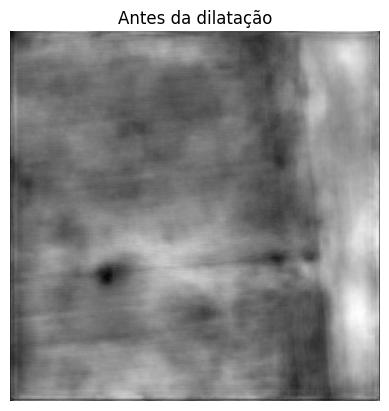

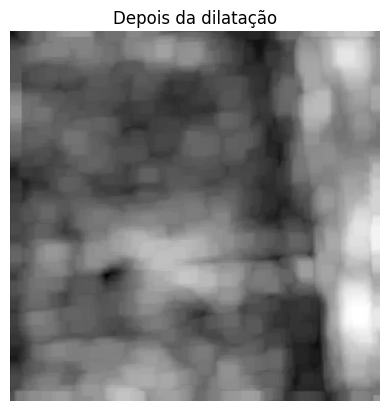

epoch: 0; lr 0.0002020; Loss 0.0871 (0.0871); cce_loss 0.0871 (0.0871); Dice 0.5252 (0.5252):   1%|          | 1/86 [00:10<14:24, 10.17s/it]

(512, 512)


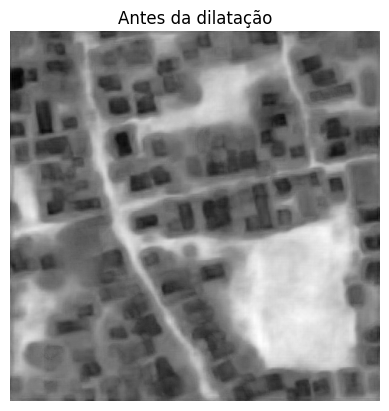

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dc747143250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 
epoch: 0; lr 0.0002020; Loss 0.0871 (0.0871); cce_loss 0.0871 (0.0871); Dice 0.5252 (0.5252):   1%| 

OutOfMemoryError: CUDA out of memory. Tried to allocate 8.79 GiB. GPU 0 has a total capacity of 39.56 GiB of which 4.97 GiB is free. Process 23445 has 34.58 GiB memory in use. Of the allocated memory 25.34 GiB is allocated by PyTorch, and 8.73 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [97]:
import ssl

random_combinations = [
    (['after_conv10'],['dilatation'], [3], ['square']),
]

for layers, ops, k_sizes, shape_types in random_combinations:
    ssl._create_default_https_context = ssl._create_unverified_context
    t0 = timeit.default_timer()

    params = model.parameters()

    optimizer = AdamW(params, lr=0.000202, weight_decay=1e-6)     #0.002

    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[5, 13, 19, 23, 28, 47, 50, 60, 70, 90, 110, 130, 150, 170, 180, 190], gamma=0.5)

    gc.collect()
    torch.cuda.empty_cache()

    model = nn.DataParallel(model).cuda()

    seg_loss = ComboLoss({'dice': 0.5, 'focal': 2.0}, per_image=False).cuda()
    ce_loss = nn.CrossEntropyLoss().cuda()
    seg_lossSeesaw = None#SeesawLoss2().cuda()

    best_score = 0
    torch.cuda.empty_cache()
    for epoch in range(10):
        train_metrics = train_epoch(epoch, seg_loss, ce_loss, seg_lossSeesaw, model, optimizer, scheduler, train_data_loader)
        gc.collect()
        torch.cuda.empty_cache()
        if epoch % 2 == 0 and epoch >= 4:
          torch.save(model.state_dict(), f'/content/drive/MyDrive/Modeling Satelities Images Building Damaged/models/after_conv10_{ops}_{k_sizes}_{shape_types}.pth')
          best_score, d = evaluate_val(val_data_loader, best_score, model, snapshot_name, epoch)
        try:
          results = pd.read_csv(f'/content/drive/MyDrive/Modeling Satelities Images Building Damaged/models/test_train_6/results_morofologic_{ops}_{k_sizes}_{shape_types}.csv')
          results_iter = pd.DataFrame([[epoch, train_metrics[0], train_metrics[1].avg, train_metrics[2].avg, train_metrics[3].avg, layers, ops, k_sizes, shape_types, d[0], d[1], d[2], d[3], d[4], d[5], d[6]]],columns=results.columns)
        except:
          results_iter = pd.DataFrame([[epoch, train_metrics[0], train_metrics[1].avg, train_metrics[2].avg, train_metrics[3].avg, layers, ops, k_sizes, shape_types, None, None, None, None, None, None, None]],columns=results.columns)
        results = pd.concat([results,results_iter])
        d = None
        results.to_csv(f'/content/drive/MyDrive/Modeling Satelities Images Building Damaged/models/test_train_6/results_morofologic_{ops}_{k_sizes}_{shape_types}.csv', index=False)

    try:
      #del model
      torch.cuda.empty_cache()
    except:
      None

    elapsed = timeit.default_timer() - t0
    print('Time: {:.3f} min'.format(elapsed / 60))

In [98]:
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

Wed Jan 31 16:46:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              50W / 400W |  35421MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [99]:
model = None
del model
torch.cuda.empty_cache()

In [ ]:
import torch

In [ ]:
x=torch.randn(12, 64, 512, 512)
e=Erosion2d(64, 4, 3, soft_max=False)
y=e(x)

In [ ]:
x.shape

torch.Size([12, 64, 512, 512])

In [ ]:
e.weight.shape

torch.Size([4, 64, 3, 3])

In [ ]:
y.shape

torch.Size([12, 4, 512, 512])

In [ ]:
e=Dilation2d(4, 64, 3, soft_max=False)
y_2=e(y)

In [ ]:
y_2.shape

torch.Size([12, 64, 512, 512])